Thomas Rüegg, Patrick Wissiak

# TODO before we submit notebook

- check import statements if all of them are actually needed
- ensure we differenciate between test and validation sets
- check goodnotes

# The Dataset

We used this dataset for our miniproject: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

The dataset contains 6 classes of images: `building`, `forest`, `glacier`, `mountain`, `sea`, and `street`. We decided to delete the class `street` and it's corresponding pictures to simplify the learning process. The images are divided into folders with their respective labels. We used the `image_dataset_from_directory` method of Keras to convert the images into a TensorFlow dataset object for training.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from sklearn import metrics

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12766289403677435905
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 4772515310648762012
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2023-03-16 10:10:46.622435: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 10:10:46.622457: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Importing the Data

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory
training_img_path = "./dataset/seg_train/seg_train/"

img_size = 150
batch_size = 32
seed = 42   # the seed will make sure the two datasets are not overlapping

train_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
test_ds = image_dataset_from_directory(
    './dataset/seg_test/seg_test',
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

ds = test_ds.unbatch()
ds = list(ds.as_numpy_iterator())
test_images = [x for x, y in ds]
test_labels = [y for x, y in ds]


full_train_dataset = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    seed=seed,
    image_size=(img_size, img_size)
)

ds = full_train_dataset.unbatch()
ds = list(ds.as_numpy_iterator())
train_images = np.array([x for x, y in ds])
train_labels = np.array([y for x, y in ds])

Found 2666 files belonging to 5 classes.
Using 2133 files for training.
Found 2666 files belonging to 5 classes.
Using 533 files for validation.
Found 2499 files belonging to 5 classes.
Found 2666 files belonging to 5 classes.


## Common functionalities

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomZoom, Rescaling, RandomFlip

data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

In [8]:
def show_images(title, augment = False):
  plt.figure(figsize=(5, 5))
  plt.suptitle(title)

  for i in range(9):
    if augment:
      # Convert to shape with batch for prediction
      img = np.reshape(test_images[i], (1, img_size, img_size, 3))
      img = data_augmentation(img).numpy()
      # Reshape back to normal image
      img = np.reshape(img, (img_size, img_size, 3))
    else:
      img = test_images[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(train_ds.class_names[test_labels[i]])
    plt.axis("off")

### Visualize the Results

In [9]:
def visualize_results(history):
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['Train','Val'], loc= 'upper left')
    plt.show() 

    plt.figure(figsize=(10,3))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [10]:
def show_images_with_predictions(model):
    plt.figure(figsize=(15, 15))
    for i in range(12):
        img = np.reshape(test_images[i], (1, img_size, img_size, 3))
        pred = model.predict(img).flatten()
        pred_idx = np.argmax(pred)
        pred_perc = "{:.2f}".format(pred[pred_idx])
        true_label = test_ds.class_names[test_labels[i]]
        pred_label = test_ds.class_names[pred_idx]
        true_label_perc = "{:.2f}".format(pred[test_labels[i]])
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(test_images[i].astype("uint8"))
        plt.title(f"True: {true_label}, {true_label_perc}\nPred: {pred_label}, {pred_perc}")
        plt.axis("off")

In [26]:
def show_confusion_matrix(model): 
    true_labels = np.array([], dtype=np.uint8)
    pred_labels = np.array([], dtype=np.uint8)
    for images_batch, true_labels_batch in test_ds:
        pred_labels_batch = np.argmax(model.predict(images_batch), axis=-1)
        true_labels = np.concatenate([true_labels, true_labels_batch])
        pred_labels = np.concatenate([pred_labels, pred_labels_batch])

    confusion_matrix = metrics.confusion_matrix(y_true=true_labels, y_pred=pred_labels)
    display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=test_ds.class_names)
    display.plot()
    plt.show()
    return true_labels, pred_labels

# Underfitting Model
We will create a model that is too simple and won't describe the data accurately enough.

## Building the Model
We start with a convolutional layer that'll import the images and use the ReLU activation function (we use that activation function for all the convolution and dense layers). Using a saturating activation function (like e.g. hyperbolic tangent tanh) would not be as efficient, but it would not contribute to underfitting. It would only make the model slower. That's why we use the more efficient non-saturating activation function ReLU.

The next layer will run a kernel of $3 \times 3$ over each image, 6 times. `padding=same` is referring to the padding of the image (needed because of the kernel size) being filled with zeros.  We have set the stride of the first convolutional layer to (3, 3). This was needed (for the underfitting model at least) to ensure there are no more than 5000 parameters.
It's similar to downscaling the the images from $150 \times 150px$ to $50 \times 50px$. We did not rescale the images in the beginning, because this way, we are able to preserve the quality of the images within the plots. Furthermore, we did not notice any increase in runtime, each epoch took the same amount of time to calculate (thanks to the GPU acceleration with tensorflow-metal, more on that later).

After that there's a `MaxPooling2D` layer which goes through the feature map (output of the `Conv2D` layer) and only takes the most relevant information.

Following that is another convolution layer and max pooling layer. Next, the image will be flattened into a vector, ready to be fed to the following dense layer. 

The last layer is a dense layer which represents the output layer, having a shared softmax activation layer to determine the probabilities of the 5 different classes.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


def create_model_underfitting():
    model = Sequential([
        Conv2D(6, (3,3), input_shape=(img_size,img_size,3), activation='relu', padding='same', strides=(3,3)),
        MaxPooling2D(),

        Conv2D(6, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        Flatten(),
        Dense(5, activation='softmax')
    ])
    model._name='underfitting_model'

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [12]:
model_underfitting = create_model_underfitting()
model_underfitting.summary()

Model: "underfitting_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 6)         168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 6)         330       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 6)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 864)               0         
                                                                 
 dense (Dense)               (None, 5)          

### Dropout?

At first we had some more dense layers in our underfitting model, and we were thinking if we should apply dropout to some of them. This is now no longer relevant (because the current model only has one dense layer), but we wanted to share our findings.

We ended up halfing the amount of nodes of those layers for the underfitting model. Why? We learned that the difference between applying `dropout(0.5)` and halving the nodes of the layer is that dropout randomly drops out nodes (more precisely, it reduces the weights to 0) during each training iteration, which means that **different** nodes will be dropped out in each iteration. This allows the network to learn more robust and generalizable representations of the data, as it is forced to rely on a subset of nodes in each iteration, which prevents overfitting. Each node needs to supply relevant information to the next layer on it's own, as the next layer's node can no longer depend on the combination of information from the previous nodes (because some nodes are not there anymore). Also, dropout is present during training, but not during inference. 

While, on the other hand, halving the nodes reduces the number of nodes in the layer permanently, which means that the network has less capacity to learn and represent complex patterns in the data. This then leads to underfitting, where the model is not able to capture the important features in the data. Which is exactly what we want.

## Training the Model

In [13]:
history = model_underfitting.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
 1/67 [..............................] - ETA: 18s - loss: 109.0848 - accuracy: 0.1250

2023-03-16 10:02:01.203810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 1s 13ms/step - loss: 14.3165 - accuracy: 0.2386 - val_loss: 2.1512 - val_accuracy: 0.2420
Epoch 2/30
 1/67 [..............................] - ETA: 1s - loss: 2.7602 - accuracy: 0.2500

2023-03-16 10:02:02.042458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 1s 10ms/step - loss: 1.7861 - accuracy: 0.2339 - val_loss: 1.6967 - val_accuracy: 0.2420
Epoch 3/30
67/67 [==============================] - 1s 10ms/step - loss: 1.6405 - accuracy: 0.2302 - val_loss: 1.6749 - val_accuracy: 0.2364
Epoch 4/30
67/67 [==============================] - 1s 10ms/step - loss: 1.6077 - accuracy: 0.2353 - val_loss: 1.6739 - val_accuracy: 0.2345
Epoch 5/30
67/67 [==============================] - 1s 10ms/step - loss: 1.5862 - accuracy: 0.2466 - val_loss: 1.6804 - val_accuracy: 0.2383
Epoch 6/30
67/67 [==============================] - 1s 9ms/step - loss: 1.5640 - accuracy: 0.2588 - val_loss: 1.6935 - val_accuracy: 0.2402
Epoch 7/30
67/67 [==============================] - 1s 10ms/step - loss: 1.5440 - accuracy: 0.2733 - val_loss: 1.6941 - val_accuracy: 0.2458
Epoch 8/30
67/67 [==============================] - 1s 10ms/step - loss: 1.5245 - accuracy: 0.2818 - val_loss: 1.7068 - val_accuracy: 0.2608
Epoch 9/30
67/67 [=======

## Visualize and analyze the model
Now, we'll have a look at how well the model performs.

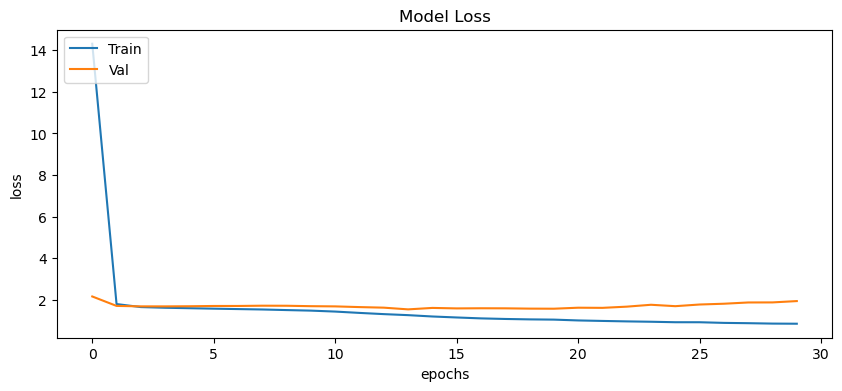

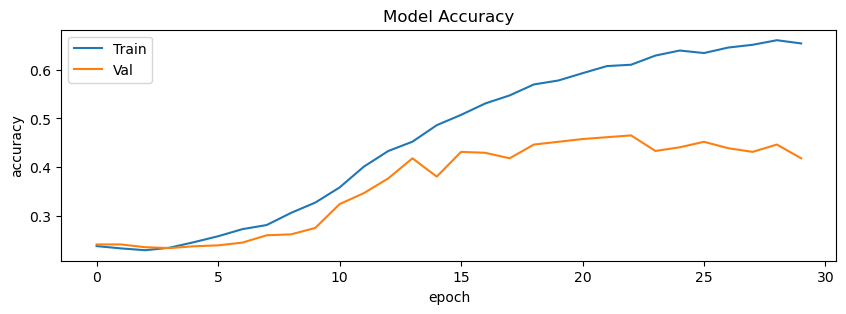

In [15]:
visualize_results(history)

We can see from the learning curves that the model slowly converges and that the model therefore is underfitting. Both the training and validation accuracy curves plateau at a low value, indicating that the model is not learning the patterns in the data well enough.

### Make predictions on the test dataset

1/1 [==============================] - 0s 9ms/step


2023-03-16 10:08:09.496231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 8ms/step


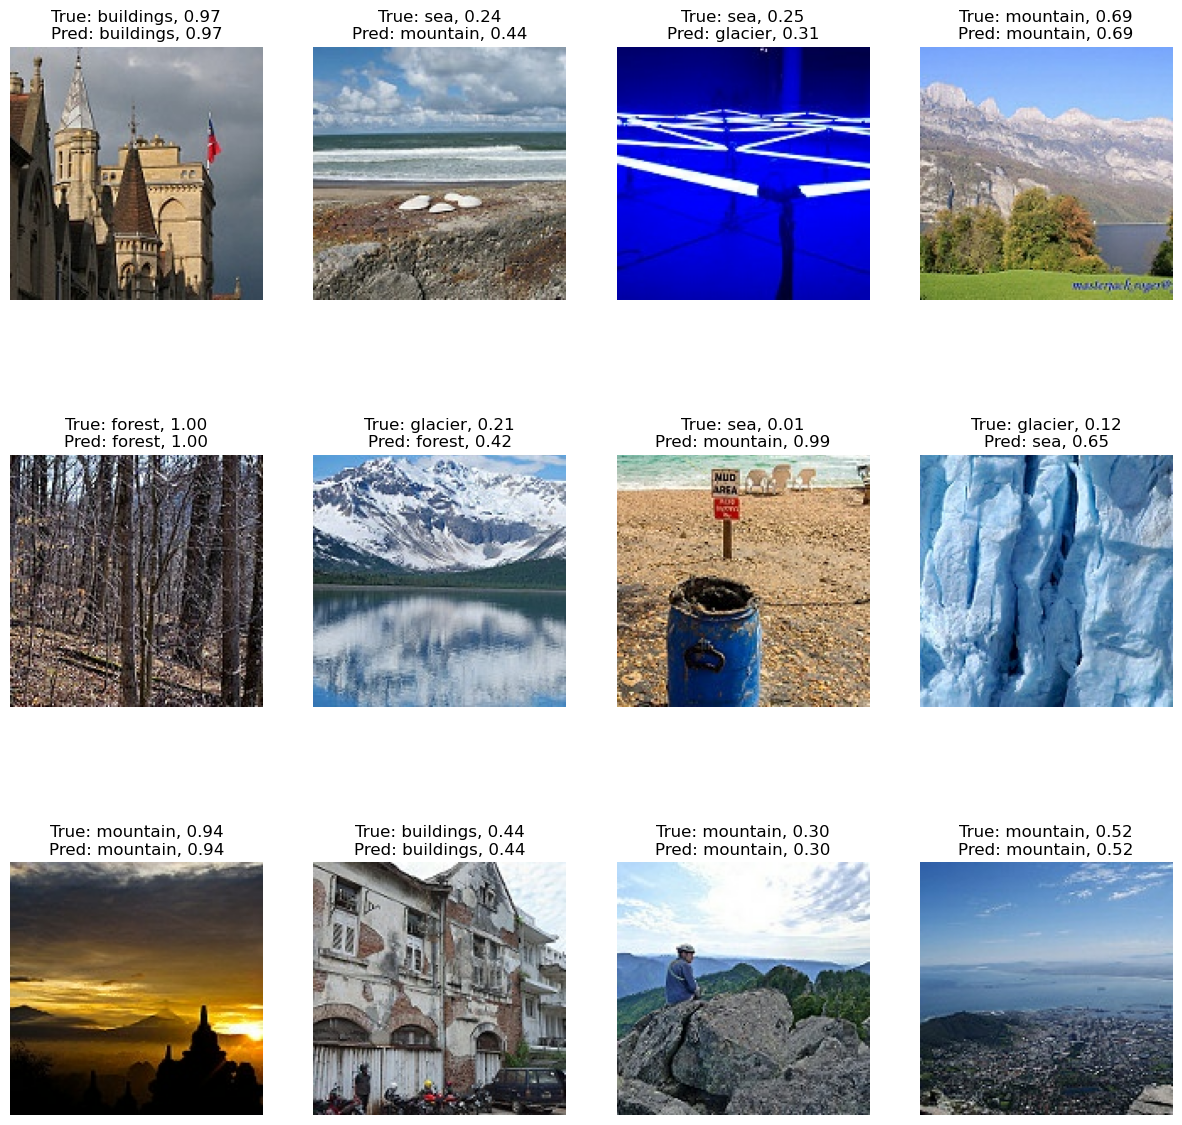

In [16]:
show_images_with_predictions(model_underfitting)

## Evaluate the performance of the model

In [18]:
print(f'Accuracy: {model_underfitting.evaluate(test_ds)[1]}')

79/79 [==============================] - 1s 6ms/step - loss: 1.9398 - accuracy: 0.4446
Accuracy: 0.44457781314849854


## Confusion Matrix
The confusion matrix is another way to visualize the performance of the model and whether it is underfitting or not.

1/1 [==============================] - 0s 10ms/step


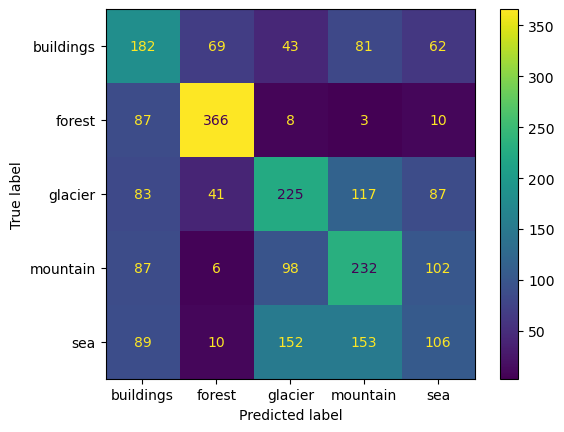

In [27]:
true_labels, pred_labels = show_confusion_matrix(model_underfitting)

## Classification Report

In [28]:
print('Classification Report:\n', metrics.classification_report(y_true=true_labels, y_pred=pred_labels))

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.42      0.38       437
           1       0.74      0.77      0.76       474
           2       0.43      0.41      0.42       553
           3       0.40      0.44      0.42       525
           4       0.29      0.21      0.24       510

    accuracy                           0.44      2499
   macro avg       0.44      0.45      0.44      2499
weighted avg       0.44      0.44      0.44      2499



The classification report shows precision, recall, f1-score and support. Looking at the classification report above, for our underfitting model, it seems pretty bad. With a precision (proportion of true positive predictions among all positive predictions) rate low for all classes, same with the recall score, resulting in a low f1-score (mean of precision and recall), it means the model is not good enough for our task.

Support is the number of actual occurrences (images) of a class in the specified dataset. Unbalanced support in the training data may indicate structural weaknesses in the reported results of the classifier and could mean that stratified sampling or rebalancing is needed, which is not the case with our dataset.

# Overfitting Model
The model is too complex and adapts perfectly on the training images but performs poorly on the test data.

The learning curve of the overfitting model will show that the accuracy on the training set is high and improving over time, while the accuracy on the validation set is lower and plateauing or even decreasing over time.

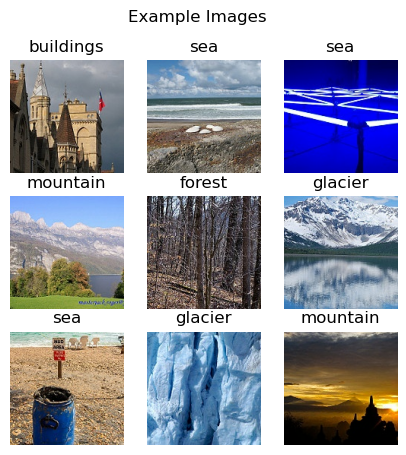

In [61]:
show_images("Example Images", augment=False)

## Building the Model
The SparseCategoricalCrossentropy calculates the loss of a categorical model with labels provided as integer values. 

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model_overfitting():
    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape= (img_size,img_size,3), activation = 'relu', padding = 'same')) #padding = same size output
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model._name = "overfitting_model"

    return model

In [63]:
overfitting_model = create_model_overfitting()
overfitting_model.summary()

Model: "overfitting_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 18, 18, 128)

## Training the Model
Learnings: In each epoch all images are sent into the CNN and through backpropagation the weights get adapted. The output of the `model.fit()` process outputs e.g.
```
Epoch 1/20
35/163 [==============================]
```
which indicates that the CNN is currently training the 35th batch of 162 batches of the first epoch. If we use a batch_size of 32 we can then calculate the number of images included in the training step -> 163*32=5216.
The number of epochs defines how many times the CNN sees the **entire** dataset but in a different order.

Another outcome that we've encountered is that the `model.fit()` process needs at least 20 epochs to converge sufficiently so that the overfitting phenomenon is visible in the Loss and Accuracy graph.

In [20]:
history = overfitting_model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=20,
)

Epoch 1/20


2023-03-16 09:22:32.495966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 7.4351 - accuracy: 0.4463

2023-03-16 09:22:35.701761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 4s 51ms/step - loss: 7.4351 - accuracy: 0.4463 - val_loss: 1.0949 - val_accuracy: 0.5403
Epoch 2/20
67/67 [==============================] - 3s 47ms/step - loss: 0.9911 - accuracy: 0.6053 - val_loss: 1.0271 - val_accuracy: 0.5891
Epoch 3/20
67/67 [==============================] - 3s 49ms/step - loss: 0.8856 - accuracy: 0.6385 - val_loss: 0.8272 - val_accuracy: 0.6811
Epoch 4/20
67/67 [==============================] - 3s 47ms/step - loss: 0.8175 - accuracy: 0.6765 - val_loss: 0.8432 - val_accuracy: 0.6792
Epoch 5/20
67/67 [==============================] - 3s 48ms/step - loss: 0.7624 - accuracy: 0.7089 - val_loss: 0.8058 - val_accuracy: 0.6961
Epoch 6/20
67/67 [==============================] - 3s 48ms/step - loss: 0.6216 - accuracy: 0.7642 - val_loss: 0.8017 - val_accuracy: 0.7298
Epoch 7/20
67/67 [==============================] - 3s 47ms/step - loss: 0.5482 - accuracy: 0.7937 - val_loss: 0.8156 - val_accuracy: 0.7054
Epoch 8/20
67/67 [======

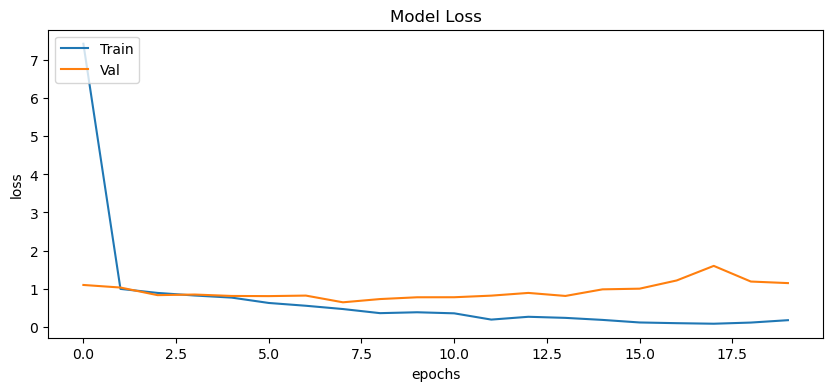

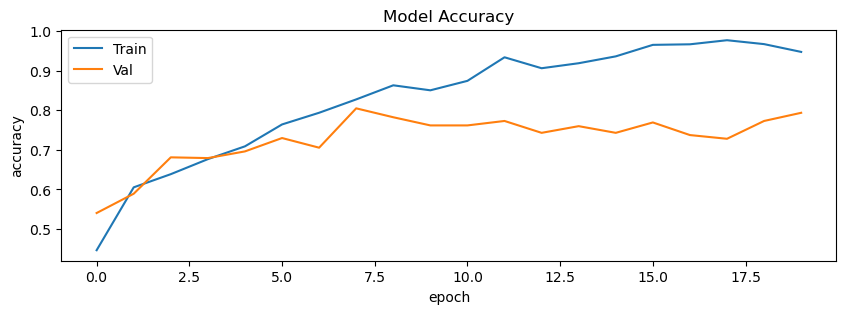

In [23]:
visualize_results(history)

In [24]:
overfitting_model.evaluate(test_ds)

79/79 [==============================] - 2s 19ms/step - loss: 1.2751 - accuracy: 0.7471


[1.275134801864624, 0.7470988631248474]

1/1 [==============================] - 0s 11ms/step


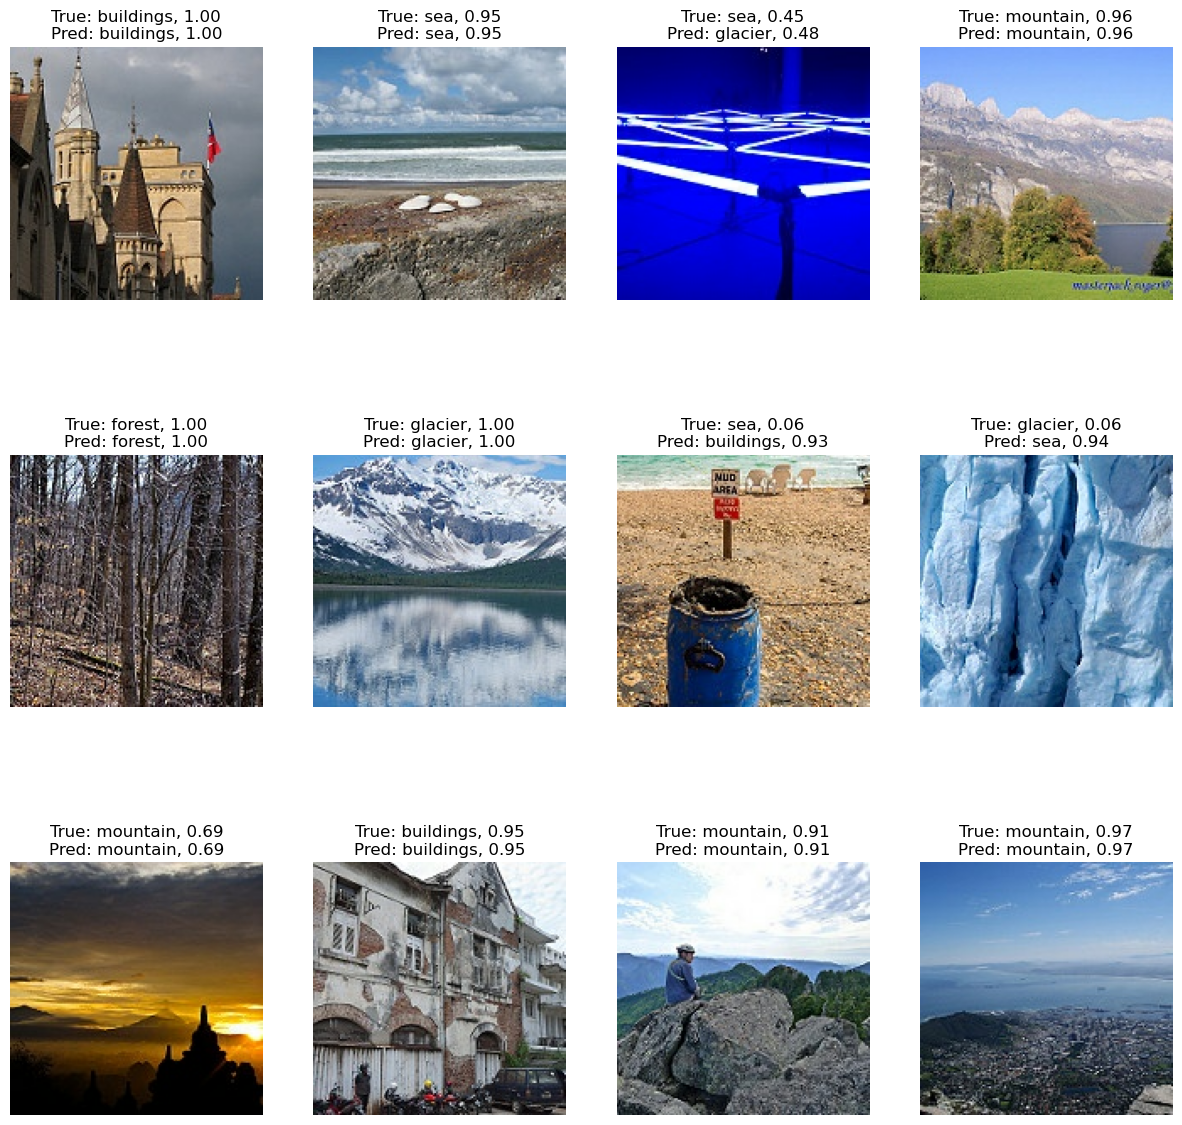

In [33]:
show_images_with_predictions(overfitting_model)

# Optimized Model
This model does not show under- or overfitting and performs well on both, training and testing data. Afterwards, a brief description on how to tackle the challenges of an optimal model complexity. 

To address underfitting, one approach is to increase the complexity of the model by adding more layers or increasing the number of filters in each layer. To address overfitting, we can try several approaches. One approach is to simplify the model by removing some layers or decreasing the number of filters in each layer. Another approach is to use less epochs for example.




Adding dropout or weight decay can help to address both of the above mentioned issues. We can also try adjusting the hyperparameters such as learning rate, batch size, or number of epochs.

## GPU Acceleration
We found out that training a model on images can be a very time consuming task, especially if many images are involved. Randomly we stumbled upon an article that stated about "GPU Acceleration" which sounded pretty interesting. Afterwards, we read a bit about the topic and found out that it is possible on our Apple M1 Pro / M2 Pro chips. After a lot of trial and error we ended up using the tensorflow-macos and tensorflow-metal packages but with specific versions because the newest versions did not work. With the both packages installed correctly, both the CPU and GPU are being used for training. The CPU on the M2 Pro chip has 12 cores and a 19 core GPU. The total of 31 cores over 12 cores already indicates that usage of the GPU would lead to massive performance improvements. The following image shows the CPU and GPU usage during training of the optimized model:
![GPU Acceleration](gpu-acceleration.png "GPU Acceleration")

When we were utilizing the CPU only training took ~100s per epoch for the overfitting model (~11'000'000 trainable parameters). After enabling GPU acceleration we came down to astonishing ~10s per epoch. This factor of 10 improvement was even more than we hoped and enabled us to test more parameters because training took about 2 minutes instead of the usual 20 minutes.

## Data Augmentation
Data Augmentation has proven to be a useful tool for model generalization. We've compared the same model with and without data augmentation and the results show that the model without data augmentation tends to overfit while the model with data augmentation doesn't:
![Data Augmentation Result](comparison-data-agumentation.jpg "Data Augmentation Result")

During this project we've also encountered some downsides of data augmentation. One apparent downside is that it drastically slows down the training because the images are being preprocessed. Another downside is that data augmentation somehow fails in combination with GridSearchCV which we've encountered only accidentially and already thought that our model is the problem why the learning curve converged in the second step at an accuary of 0.2.

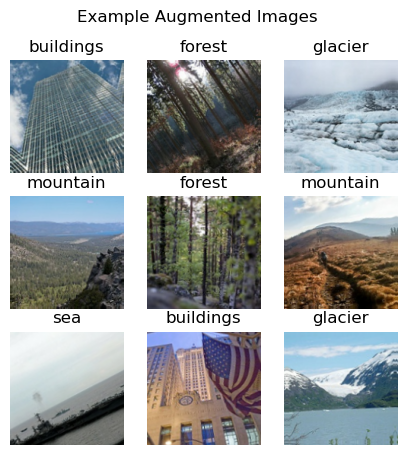

In [53]:
show_images("Example Augmented Images", augment=True)

## Building the Model
As a baseline we used the same model as the overfitting one but we add some extras to reduce the overfitting behavior.

### Regularization
Regularization is used to reduce the impact impact of the weights. The weights then end up having less impact on the loss function which determines the error between the actual label and predicted label. This reduces complexity of the model and therefore reduces overfitting. We are adding regularization only to those layers which have the largest number of parameters according to the model summary. We are using L2 (Ridge) regularization since it predetermined from the task. We are adding L2 mainly to the layers that add the most parameters to the CNN.

Dropout Layers: The benefit of using dropout is no node in the network will be assigned with high parameter values, as a a result the parameter values will be dispersed and the output of the current layer will not depend on a single node.
E.g. Dropout(0.2) drops the input layers at a probability of 0.2. Dropout is applied per batch size, so the parameters get tuned for a full batch size with missing input parameters which results in lower generalization errors. 

### Generalization
To improve generalization of the model, data augmentation is a useful tool. With data augmentation we can add artificial effects to the images such as flipping and rotating. Through these effects, the images always appear differently each time they appear in the training step and therefore the CNN doesn't adapt to the exact images but rather learns about the relative features inside of an image.

### Optimizer
For the optimized model we chose Adam over the competitors because it is the most common among SGD. We tried out SGD but it performed very poorly compared to Adam which might be due to insufficient configuration of the learning rate. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order (mean) and second-order (uncentered variance) moments. Its default implementation already provides a form of annealed learning, beta_1=0.9 for the first-order moment and beta_2=0.999 for the second-order moment. 

### Activation Function
The [following article](https://thangasami.medium.com/cnn-and-ann-performance-with-different-activation-functions-like-relu-selu-elu-sigmoid-gelu-etc-c542dd3b1365) states that ReLU is the overall the best suited activation function so based on this we decided to use ReLU for our optimized model.

### Batch Size
The batch size defines how many samples (images here) run through the Neural Network before the weights get adapted. It is recommended to use mini batches to update the Neural Network multiple times during an epoch. We've tried out differnt batch sizes with the same seed on the image generator TODO

## Layers
### First Layer
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network because in general, the input values should be small. Therefore we use the Rescaling layer as a normalization layer. 

### Dropout
With Cross-Validation we've tried out different dropout params (0.2, 0.3, 0.4) for the layer before the dense layers. The results are pretty similar but the 0.3 dropout seems to be more stable at the end of 30 epochs so we used this parameter for the model. The steep spikes of accuracy in the first few epochs are expected because due to dropout, some parameters are missing everytime and the model improves a lot over a short period of time because other parameters are being dropped out at every epoch. 
![Last Layer Dropout](history-data/dropout-param-5fold-cv.png "Last Layer Dropout")

### Last Layer
For the last layer we tried out 512, 1024 and 2048 trainable parameters and the Cross-Validation result was that the accuracy and loss were not drastically affected but the network with 2048 parameters in the last layer was much more stable than the others. Based on this fact, we sticked with using 2048 parameters in the last layer.
![CV Last Layer](history-data/last-layer-param-5fold-cv.png "CV Last Layer")

### Loss Function
Because we use the SoftMax activation function as the output of the last Dense Layer, we get normalized probabilites, [0, 1]. The SparseCategoricalCrossentry function's from_logits=True would expect Logits which are in the range of [-inf, +inf] and therefore, we use from_logits=False.¨

As the optimizer, we also tried out SGD with annealed learning but in the course of 20 epochs we reached poorer results than with adam.

In [64]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

def create_model_optimized(l2_param=0.001, last_dropout_param=0.3, last_layer_param=512, augment=True):
    model = Sequential()

    if augment:
        model.add(data_augmentation)
        model.add(Rescaling(1./255))

    model.add(Conv2D(32, (3,3), input_shape= (img_size,img_size, 3), activation = 'relu', padding = 'same')) #padding = same size output
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())

    model.add(Conv2D(last_layer_param, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Dropout(last_dropout_param))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(
       optimizer = 'adam', 
       loss=SparseCategoricalCrossentropy(from_logits=False), 
       metrics=['accuracy']
    )

    return model

## Cross Validation for Parameter Optimization
For k-fold Cross Validation parameter optimization we are using a sklearn's KFold method paired with a custom functionality to fit the model with different parameter values. We tried to use GridSearchCV (as we did in the AI Foundation course) but we first thought that the model parameters (such as the regularization parameter of the 2nd Conv2D layer) are not accessible from the `param_grid` that is passed to GridSearchCV (which we later found out is not the case). We then came up with a custom KFold Cross Validation approach which is fully flexible and uses if-else statements in the model creation step. With this Cross Validation implementation we've tuned parameters such as the l2 regularization paramter, the number of trainable parameters in the last Conv2D layer or the percentage of dropout before the dense layers.

The following image visualizes the results of the l2 regularization parameter. We tested for the values 0.01, 0.001 and 0.0001 and ran a 5-fold Cross Validation with 10 epochs for each value. The regularizer is being used in three Conv2D layers of the model. As from the diagram below it is apparent that the accuracy improved the smaller the l2 regularization parameter became and, therefore, we decided to use l2=0.0001. 
![l2 Parameter Optimization](history-data/l2-param-5fold-cv.png "l2 Parameter Optimization")

### Development of the kFold CV Functionality
The part of splitting the full dataset into testing and validation data by the indices obtained by the KFold split was pretty tricky. We've encountered that it is not always convenient and easy to handle the tensorflow data. Especially without experience of the huge framework it was difficult to find information about splitting a dataset and we ended up trying out numerous ways. In the end we consulted ChatGPT which lead us in the right direction. One problem we've had is that the generated filtering functionality did not work directly and after reading the documentation of the filter method, it was not clear which parameters are being passed to this function. Also, it is surprising that tensorflow doesn't seem to have an out-of-the-box solution for such a dataset split. In the end we found out how the methods works and the implementation was successful.

The current solution is not optimal because the `.filter(... reduce_any(...))` is not performant and massively slows down the training which would be important to improve in a real project. Nevertheless, the implementation works and enabled us to make sophisticated comparisons of the model parameters. 

During the usage of the intense training functionality of KFold Cross Validation we encountered a problem using tensorflow-metal with GPU acceleration. The problem is that the python process hangs up after approximately the 8-th fold of a 10 epoch training process. This was very inconvenient because we were not able to perform the parameter optimization in one step and needed to temporarily store the results for each parameter which we made by saving the results in a JSON file. Luckily, we were able to perform the 5-fold Cross Validation of at least one parameter before the process hung up. The issue of this behavior is known but does not seem to be fixed yet, as can be seen [here]( https://developer.apple.com/forums/thread/713944). 

In [69]:
import itertools
from sklearn.model_selection import KFold
import tensorflow as tf
import json

param_grid=dict(
    # last_layer_param=[512, 1024, 2048]
    l2_param=[0.01, 0.001, 0.0001],
    augment=[False],
    # last_dropout_param=[0.2, 0.3, 0.4]
)
epochs = 30
folds = 5

keys = list(param_grid.keys())
params = list(param_grid.get(x) for x in keys)
param_permutations = list(itertools.product(*params))

model_history = dict()

kfold = KFold(n_splits=folds, shuffle=True)

for perm in param_permutations:
    model_args = dict()
    for index in range(len(params)):
        key = keys[index]
        value = perm[index]
        model_args[key] = value

    # Set title according to the params for later visualization
    title = ", ".join(list((key + ": " + str(model_args[key])) for key in model_args.keys()))
    
    print("CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS: " + title)
    model_history[title] = []

    for fold, (train_indices, val_indices) in enumerate(kfold.split(train_images)):
        print(f'Fold {fold+1}/{folds}, (params={title})')

        X_train, y_train = train_images[train_indices], train_labels[train_indices]
        X_val, y_val = train_images[val_indices], train_labels[val_indices]

        model = create_model_optimized(**model_args)
        
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs
        )

        # Evaluate the model on the validation dataset for this fold
        loss, acc = model.evaluate(test_ds)
        print(f'Test accuracy: {acc:.3f}\n')

        # Use title as key for easy usage
        model_history[title].append(dict(fold=fold, loss=loss, acc=acc, history=history))

    with open(f'model-history-{title}.json', 'w') as f:
        json.dump(model_history, f, default=lambda o: '<not serializable>')

CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS: l2_param: 0.01, augment: False
Fold 1/5, (params=l2_param: 0.01, augment: False)
Epoch 1/30


2023-03-16 09:41:39.399266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 16.5228 - accuracy: 0.3208

2023-03-16 09:41:43.132868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 64ms/step - loss: 16.5228 - accuracy: 0.3208 - val_loss: 6.4597 - val_accuracy: 0.5363
Epoch 2/30
54/54 [==============================] - 3s 48ms/step - loss: 5.9524 - accuracy: 0.5261 - val_loss: 5.4941 - val_accuracy: 0.6230
Epoch 3/30
54/54 [==============================] - 3s 47ms/step - loss: 5.1754 - accuracy: 0.5924 - val_loss: 4.8315 - val_accuracy: 0.6932
Epoch 4/30
54/54 [==============================] - 3s 47ms/step - loss: 4.6367 - accuracy: 0.6205 - val_loss: 4.4294 - val_accuracy: 0.6206
Epoch 5/30
54/54 [==============================] - 3s 47ms/step - loss: 4.2381 - accuracy: 0.6293 - val_loss: 4.0649 - val_accuracy: 0.6979
Epoch 6/30
54/54 [==============================] - 3s 47ms/step - loss: 3.8383 - accuracy: 0.6968 - val_loss: 3.7021 - val_accuracy: 0.7096
Epoch 7/30
54/54 [==============================] - 3s 47ms/step - loss: 3.5620 - accuracy: 0.7021 - val_loss: 3.4657 - val_accuracy: 0.7166
Epoch 8/30
25/54 [=====

KeyboardInterrupt: 

### Visualizaton of the Parameter Performance

In [ ]:
# The following data has been generated with the above custom KFold Cross Validation method
#model_history = {
#    "last_layer_param: 512": [{"fold": 0, "loss": 0.9580041766166687, "acc": 0.6450580358505249}, {"fold": 1, "loss": 0.8243932127952576, "acc": 0.685874342918396}, {"fold": 2, "loss": 1.3444817066192627, "acc": 0.5246098637580872}, {"fold": 3, "loss": 0.9893543124198914, "acc": 0.6194477677345276}, {"fold": 4, "loss": 0.8950880169868469, "acc": 0.6618647575378418}],
#    "last_layer_param: 1024": [{"fold": 0, "loss": 1.002255916595459, "acc": 0.6302521228790283}, {"fold": 1, "loss": 1.0927249193191528, "acc": 0.5918367505073547}, {"fold": 2, "loss": 1.0004750490188599, "acc": 0.6314525604248047}, {"fold": 3, "loss": 0.9172393679618835, "acc": 0.6574629545211792}, {"fold": 4, "loss": 1.024383306503296, "acc": 0.6054421663284302}],
#    "last_layer_param: 2048": [{"fold": 0, "loss": 1.1013964414596558, "acc": 0.5674269795417786}, {"fold": 1, "loss": 0.9457604289054871, "acc": 0.6214485764503479}, {"fold": 2, "loss": 1.1457700729370117, "acc": 0.5774309635162354}, {"fold": 3, "loss": 0.8856483101844788, "acc": 0.6426570415496826}, {"fold": 4, "loss": 0.9397972822189331, "acc": 0.6210483908653259}]
#}
print(model_history)
accuracies = dict()
losses = dict()
for key in model_history.keys():
    accuracies[key] = []
    losses[key] = []
    for entry in model_history[key]:
        losses[key].append(entry["loss"])
        accuracies[key].append(entry["acc"])

fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].set_title("5 Fold Cross Validation")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Parameter")
ax[0].boxplot(accuracies.values())
ax[0].set_xticklabels(accuracies.keys(), rotation=45)
ax[1].set_title("5 Fold Cross Validation")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Parameter")
ax[1].boxplot(losses.values())
ax[1].set_xticklabels(losses.keys(), rotation=45)

fig.set_figheight(15)
fig.set_figwidth(15)

In [ ]:
for m_key in model_history:
    for item in model_history.get(m_key):
        for key in item:
            if key == 'history':
                history = item.get('history')
                fold = item.get("fold")
                plt.plot(history.history['val_accuracy'], label=f"Fold {fold}")
    plt.title(f"Accuracies for {folds} Fold CV, with {m_key}")
    plt.ylabel("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.legend(loc= 'upper left')
    plt.show()

### Update with GridSearchCV
Apparently the first believe that the model parameters can't be optimized using GridSearchCV was a misperception because `model.get_params()` just did not output the expected parameters... Beause the GridSearchCV implementation does somehow not work with our model and because of the huge effort, we left the above implementation but still provide a version using GridSearchCV which is way more elegant. We believe that it is a bug of GridSearchCV that our model doesn't work with the function because the accuaracy does not improve at all and if we use less layers, it seems to work. For the details, please look at the [Issue on GitHub](https://github.com/scikit-learn/scikit-learn/issues/25825) which we've created for this behavior. 

To still use GridSearchCV, we've tried another implementation that uses tf.data.Dataset directly: [TensorCross](https://github.com/franneck94/TensorCross). Our model works with this implementation so we provide an example using this method as well. At first, TensorCross was not compatible with tensorflow-macos which we've also created a [GitHub Issue](https://github.com/franneck94/TensorCross/issues/45) for, that has been fixed very quickly so we were able to use the library. 

In [71]:
from tensorcross.model_selection import GridSearchCV

param_grid=dict(
    # last_layer_param=[256, 512, 1024],
    l2_param=[0.01, 0.001, 0.0001],
    augment=[False],
    # last_dropout_param=[0.2, 0.3, 0.4]
)
grid_search_cv = GridSearchCV(
    model_fn=create_model_optimized,
    param_grid=param_grid,
    n_folds=5,
)

grid_search_cv.fit(
    dataset=full_train_dataset,
    epochs=20,
)

Epoch 1/20


2023-03-16 09:45:43.676000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - ETA: 0s - loss: 12.4861 - accuracy: 0.4266

2023-03-16 09:45:47.625034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 5s 60ms/step - loss: 12.4861 - accuracy: 0.4266 - val_loss: 6.1123 - val_accuracy: 0.5117
Epoch 2/20
68/68 [==============================] - 3s 49ms/step - loss: 5.5066 - accuracy: 0.5766 - val_loss: 5.0894 - val_accuracy: 0.5938
Epoch 3/20
57/68 [========================>.....] - ETA: 0s - loss: 4.8152 - accuracy: 0.6179

KeyboardInterrupt: 

The GridSearchCV prints all the scores as well as the best params which is very convenient:

In [ ]:
grid_search_cv.summary()

## Training the Model
We are now training the model directly with data augmentation to make predictions on the test data and to intereprete its performance.

In [72]:
model_optimized = create_model_optimized(augment=True)
model_optimized.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                

In [73]:
history = model_optimized.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2023-03-16 09:47:20.414031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 1.6609 - accuracy: 0.4069

2023-03-16 09:47:29.895918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 10s 140ms/step - loss: 1.6609 - accuracy: 0.4069 - val_loss: 1.2125 - val_accuracy: 0.5441
Epoch 2/10
67/67 [==============================] - 9s 132ms/step - loss: 1.2269 - accuracy: 0.5518 - val_loss: 1.2557 - val_accuracy: 0.5422
Epoch 3/10
67/67 [==============================] - 9s 131ms/step - loss: 1.1018 - accuracy: 0.5781 - val_loss: 1.2003 - val_accuracy: 0.5291
Epoch 4/10
67/67 [==============================] - 9s 137ms/step - loss: 1.0432 - accuracy: 0.5996 - val_loss: 0.9845 - val_accuracy: 0.6135
Epoch 5/10
67/67 [==============================] - 9s 130ms/step - loss: 1.0019 - accuracy: 0.6104 - val_loss: 0.9302 - val_accuracy: 0.6660
Epoch 6/10
67/67 [==============================] - 9s 129ms/step - loss: 0.9270 - accuracy: 0.6367 - val_loss: 0.9560 - val_accuracy: 0.6417
Epoch 7/10
67/67 [==============================] - 9s 130ms/step - loss: 0.9064 - accuracy: 0.6657 - val_loss: 0.9278 - val_accuracy: 0.6379
Epoch 8/10
67/67

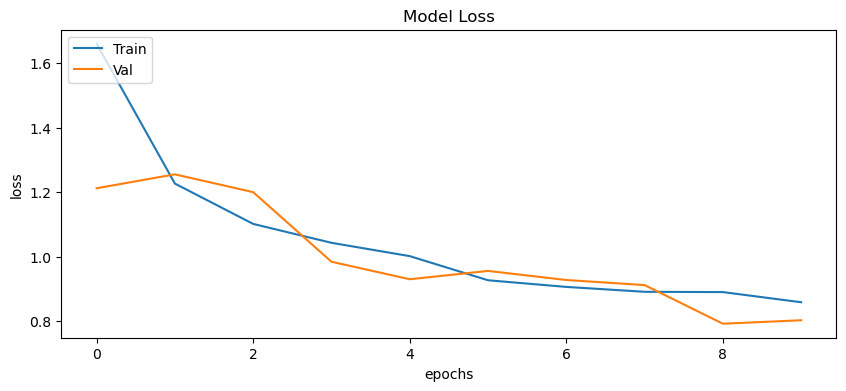

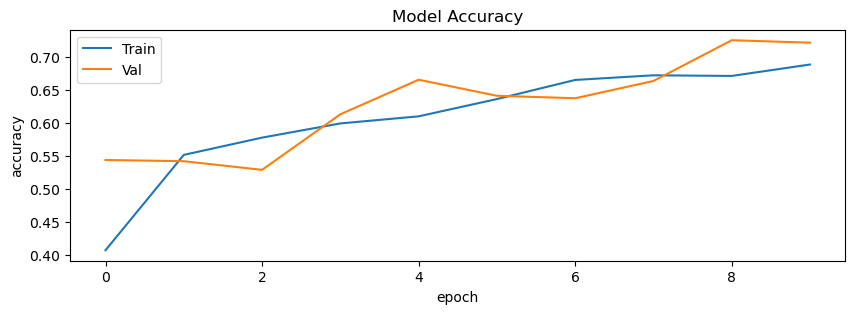

In [74]:
visualize_results(history)

In [75]:
model_optimized.evaluate(test_ds)

79/79 [==============================] - 2s 18ms/step - loss: 0.8281 - accuracy: 0.7059


[0.8280916810035706, 0.7058823704719543]

1/1 [==============================] - 0s 10ms/step


2023-03-16 09:49:16.100130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


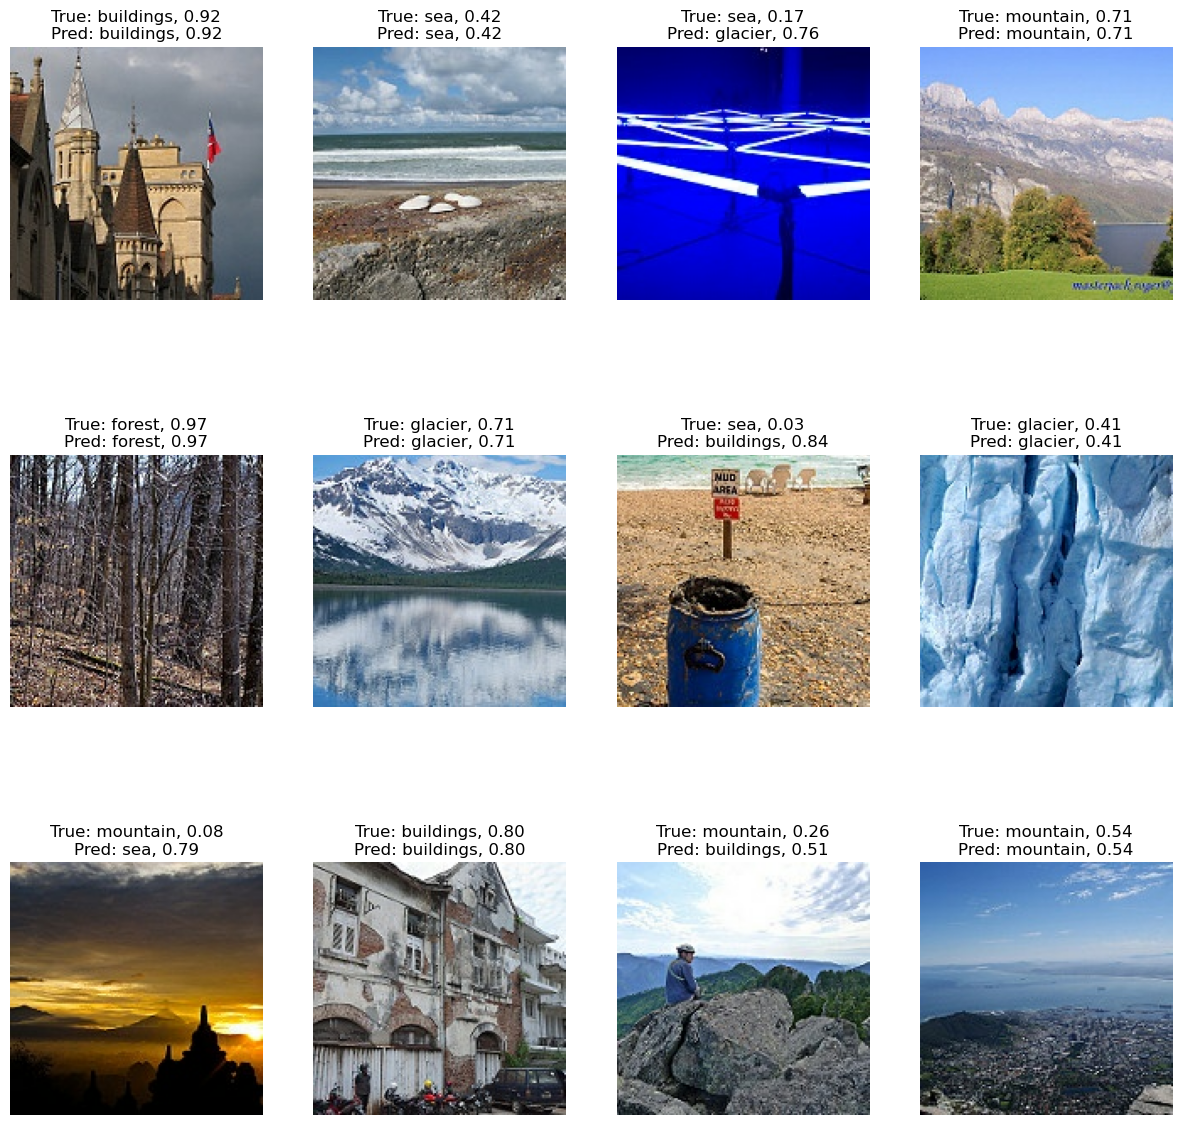

In [76]:
show_images_with_predictions(model_optimized)

## Confusion Matrix

1/1 [==============================] - 0s 53ms/step


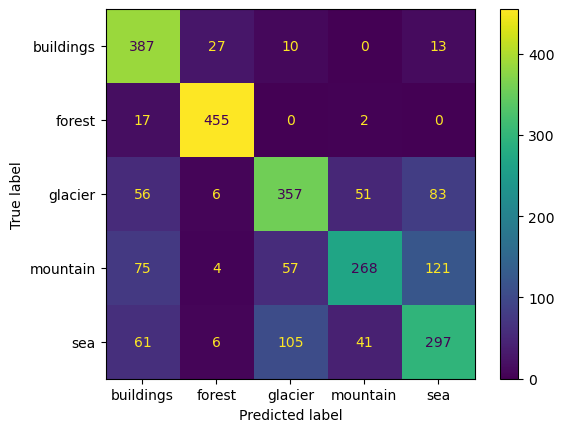

In [77]:
show_confusion_matrix(model_optimized)

As from the above Confusion Matrix, the predictions for the class forest and sea are very accurate while predictions for glacier are wrong over 50%. The class glacier got classified as sea 30% of the time which could be the ase because images of both classes contain smooth surfaces as well as blue-ish and white-ish colors. Interestingly the class sea got predicted very accurately which may indicated that the model tends to say sea instead of for example galcier if it is not a 100% clear.

# Summary
This project as exciting as it was challenging. It made us really try out numerous ways on how to tweak both performance in the sense of speed and of model accuracy. It is interesting how a small change can have a huge impact on the model's learning behavior. We've also extensively dealt with the over- and underfitting effects which consolidated our understanding on how and when to use Regularization and Generalization optimizations. 

In summary, creating a model with tensorflow is very easy and convenient but creating a performant model can be an overwhelming and time consuming process that can be frustrating at some point. But seeing the results of a successful improvement, on the other hand, is very satisfactory. The biggest difficulty in our opinion is to not loose the overview of the data handling. 

## Outlook
As a wrap-up we'd like to give a short outlook on what could be further steps to improve the model or to take the model into production.

### Export and Reuse
Tensorflow allows to export the weights of a trained model. In this way a new model can be initialized using the saved weights and can be used directly to make predictions on unseen data. This would be the method we'd use if we'd take this model to some productive use. 